# Задание 6

# Решение задачи классификации методом решающих деревьев

**Цели и задачи работы**

Цель лабораторной работы: научиться решать задачу классификации методами решающих деревьев и ансамблей на их основе.

**Основные задачи:**

• освоить метод Random Forest (Случайный лес) – алгоритма машинного обучения, относящегося к классу ансамблевых методов;

• оценить эффективность алгоритма на практическом примере;

• изучение методов визуализации модели и оценки ее корректности.


## Импортируйте необходимые библиотеки


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score

sns.set_theme(style="whitegrid", palette="crest")
np.random.seed(42)


## 1. Загрузить набор данных как датафрейм библиотеки pandas. Использовать набор данных для задания 3 (бинарная классификация).


In [15]:
data_path = "onlinefoods.csv"

df = pd.read_csv(data_path).dropna(axis=1, how='all')
df.columns = df.columns.str.strip().str.replace(' ', '_')
for col in df.select_dtypes(include='object'):
    df[col] = df[col].astype(str).str.strip()

print(f"Файл загружен: {data_path}. Размер: {df.shape[0]} строк x {df.shape[1]} столбцов")


Файл загружен: onlinefoods.csv. Размер: 388 строк x 13 столбцов


## 2. Получить представлении о наборе данных с помощью методов shape, head, describe, info библиотеки pandas.


In [16]:
print("Форма датафрейма:", df.shape)
print("\nПервые 5 строк:")
display(df.head())

print("\nОписательные статистики (числовые признаки):")
display(df.select_dtypes(include='number').describe().T)

print("\nКатегориальные признаки:")
display(df.select_dtypes(include='object').describe().T)

print("\nИнформация о столбцах:")
df.info()

print("\nПропуски по столбцам:")
display(df.isna().sum())


Форма датафрейма: (388, 13)

Первые 5 строк:


,Age,Gender,Marital_Status,Occupation,Monthly_Income,Educational_Qualifications,Family_size,latitude,longitude,Pin_code,Output,Feedback,Unnamed:_12
0,20,Female,Single,Student,No Income,Post Graduate,4,12.9766,77.5993,560001,Yes,Positive,Yes
1,24,Female,Single,Student,Below Rs.10000,Graduate,3,12.9770,77.5773,560009,Yes,Positive,Yes
2,22,Male,Single,Student,Below Rs.10000,Post Graduate,3,12.9551,77.6593,560017,Yes,Negative,Yes
3,22,Female,Single,Student,No Income,Graduate,6,12.9473,77.5616,560019,Yes,Positive,Yes
4,22,Male,Single,Student,Below Rs.10000,Post Graduate,4,12.9850,77.5533,560010,Yes,Positive,Yes



Описательные статистики (числовые признаки):


,count,mean,std,min,25%,50%,75%,max
Age,388.0,24.628866,2.975593,18.0000,23.000000,24.0000,26.000000,33.0000
Family_size,388.0,3.280928,1.351025,1.0000,2.000000,3.0000,4.000000,6.0000
latitude,388.0,12.972058,0.044489,12.8652,12.936900,12.9770,12.997025,13.1020
longitude,388.0,77.600160,0.051354,77.4842,77.565275,77.5921,77.630900,77.7582
Pin_code,388.0,560040.113402,31.399609,560001.0000,560010.750000,560033.5000,560068.000000,560109.0000



Категориальные признаки:


,count,unique,top,freq
Gender,388,2,Male,222
Marital_Status,388,3,Single,268
Occupation,388,4,Student,207
Monthly_Income,388,5,No Income,187
Educational_Qualifications,388,5,Graduate,177
Output,388,2,Yes,301
Feedback,388,2,Positive,317
Unnamed:_12,388,2,Yes,301



Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         388 non-null    int64  
 1   Gender                      388 non-null    object 
 2   Marital_Status              388 non-null    object 
 3   Occupation                  388 non-null    object 
 4   Monthly_Income              388 non-null    object 
 5   Educational_Qualifications  388 non-null    object 
 6   Family_size                 388 non-null    int64  
 7   latitude                    388 non-null    float64
 8   longitude                   388 non-null    float64
 9   Pin_code                    388 non-null    int64  
 10  Output                      388 non-null    object 
 11  Feedback                    388 non-null    object 
 12  Unnamed:_12                 388 non-null    object 
dtypes: float64(

Age                           0
Gender                        0
Marital_Status                0
Occupation                    0
Monthly_Income                0
Educational_Qualifications    0
Family_size                   0
latitude                      0
longitude                     0
Pin_code                      0
Output                        0
Feedback                      0
Unnamed:_12                   0
dtype: int64

## 3. Произвести предобработку данных:

• закодировать категориальные признаки в дискретные величины с помощью методов библиотеки sklearn;

• произвести нормализацию данных с помощью методов библиотеки sklearn.


In [17]:
target_col = 'Feedback'

# Подготовка данных для моделирования
X = df.drop(columns=[target_col])
y = df[target_col]

# Определение типов признаков
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Числовые признаки ({len(numeric_cols)}): {numeric_cols}")
print(f"Категориальные признаки ({len(categorical_cols)}): {categorical_cols}")

# Настройка предобработки: кодирование категориальных и нормализация числовых
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols),
    ]
)

# Применяем предобработку
X_processed = preprocessor.fit_transform(X)
print(f"\nРазмер матрицы признаков после предобработки: {X_processed.shape}")


Числовые признаки (5): ['Age', 'Family_size', 'latitude', 'longitude', 'Pin_code']
Категориальные признаки (7): ['Gender', 'Marital_Status', 'Occupation', 'Monthly_Income', 'Educational_Qualifications', 'Output', 'Unnamed:_12']

Размер матрицы признаков после предобработки: (388, 28)


## 4. Произвести создание и обучение модели библиотеки sklearn, реализующей Random Forest (случайный лес).


In [18]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.25, stratify=y, random_state=42
)

print(f"Размер обучающей выборки: {X_train.shape[0]} объектов")
print(f"Размер тестовой выборки: {X_test.shape[0]} объектов")

# Создание и обучение модели Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

print("\nМодель Random Forest обучена!")

# Прогнозирование
y_pred_rf = rf_model.predict(X_test)

# Оценка точности
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Точность модели Random Forest на тестовой выборке: {accuracy_rf:.4f}")


Размер обучающей выборки: 291 объектов
Размер тестовой выборки: 97 объектов

Модель Random Forest обучена!
Точность модели Random Forest на тестовой выборке: 0.8660


## 5. Сравнение с другими методами классификации (Decision Tree и Gradient Boosting)


In [19]:
# Создание и обучение базового дерева решений
base_dt = DecisionTreeClassifier(random_state=42)
base_dt.fit(X_train, y_train)
y_pred_dt = base_dt.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Точность базового дерева решений на тесте: {accuracy_dt:.4f}")

# Создание и обучение настроенного дерева решений
tuned_dt = DecisionTreeClassifier(max_depth=5, random_state=42)
tuned_dt.fit(X_train, y_train)
y_pred_tuned = tuned_dt.predict(X_test)
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print(f"Точность настроенного дерева решений (max_depth=5) на тесте: {accuracy_tuned:.4f}")

# Создание и обучение Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"Точность Gradient Boosting на тесте: {accuracy_gb:.4f}")


Точность базового дерева решений на тесте: 0.8763
Точность настроенного дерева решений (max_depth=5) на тесте: 0.8866
Точность Gradient Boosting на тесте: 0.8660


## 6. Подобрать гиперпараметры для улучшения модели.


In [20]:
# Определяем сетку параметров для перебора
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Создаем модель для поиска
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                          cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Запускаем поиск
print("Начинаем подбор гиперпараметров...")
grid_search.fit(X_train, y_train)

# Выводим лучшие параметры
print("\nЛучшие параметры:", grid_search.best_params_)
print("Лучшая точность при кросс-валидации: {:.4f}".format(grid_search.best_score_))

# Оцениваем лучшую модель на тестовых данных
best_rf_model = grid_search.best_estimator_
y_pred_best = best_rf_model.predict(X_test)
best_accuracy = accuracy_score(y_test, y_pred_best)
print(f"Точность улучшенной модели на тестовой выборке: {best_accuracy:.4f}")


Начинаем подбор гиперпараметров...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Лучшие параметры: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Лучшая точность при кросс-валидации: 0.8593
Точность улучшенной модели на тестовой выборке: 0.8557


## 7. Оценить корректность построенной модели.


Сравнение точности моделей:


,Train Accuracy,Test Accuracy
Base Decision Tree,0.989691,0.876289
Tuned Decision Tree,0.931271,0.886598
Random Forest (base),0.989691,0.865979
Random Forest (optimized),0.917526,0.855670
Gradient Boosting,0.982818,0.865979


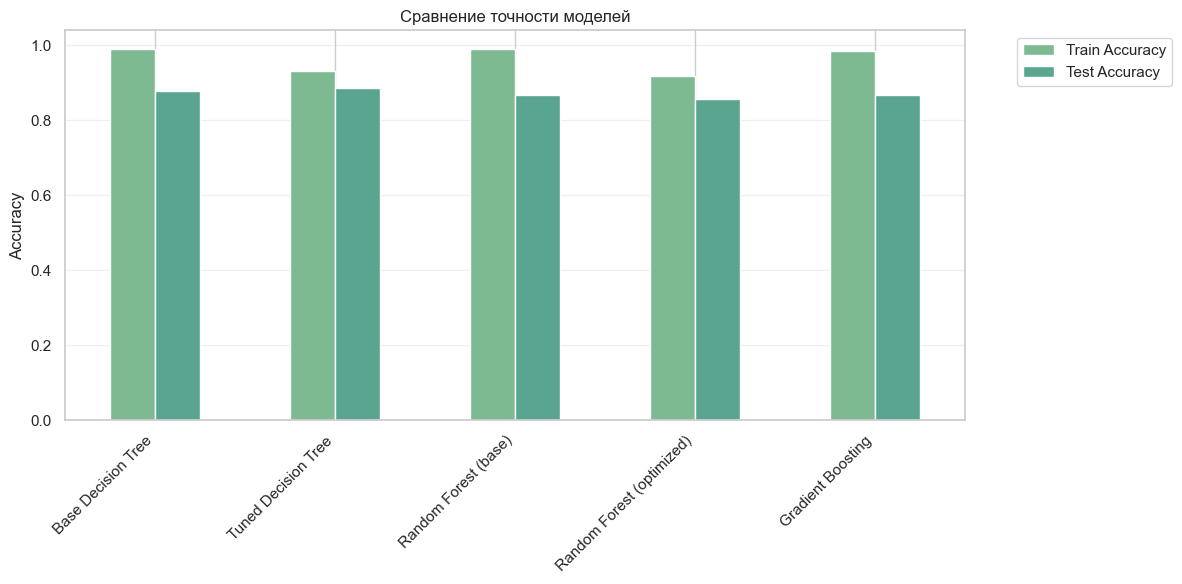

In [21]:
# Сравнение всех моделей
models = {
    'Base Decision Tree': base_dt,
    'Tuned Decision Tree': tuned_dt,
    'Random Forest (base)': rf_model,
    'Random Forest (optimized)': best_rf_model,
    'Gradient Boosting': gb_model
}

results = {}

for name, model in models.items():
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    results[name] = {'Train Accuracy': train_acc, 'Test Accuracy': test_acc}

# Выводим результаты в виде DataFrame
results_df = pd.DataFrame(results).T
print("Сравнение точности моделей:")
display(results_df)

# Строим bar-plot для наглядности
results_df[['Train Accuracy', 'Test Accuracy']].plot(kind='bar', figsize=(12, 6))
plt.title("Сравнение точности моделей")
plt.ylabel("Accuracy")
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [22]:
# Подробный отчет по классификации для лучшей модели
print("="*60)
print("Отчет по классификации (Random Forest - оптимизированная модель):")
print("="*60)
print(classification_report(y_test, y_pred_best, target_names=['Negative', 'Positive']))


Отчет по классификации (Random Forest - оптимизированная модель):
              precision    recall  f1-score   support

    Negative       0.62      0.56      0.59        18
    Positive       0.90      0.92      0.91        79

    accuracy                           0.86        97
   macro avg       0.76      0.74      0.75        97
weighted avg       0.85      0.86      0.85        97



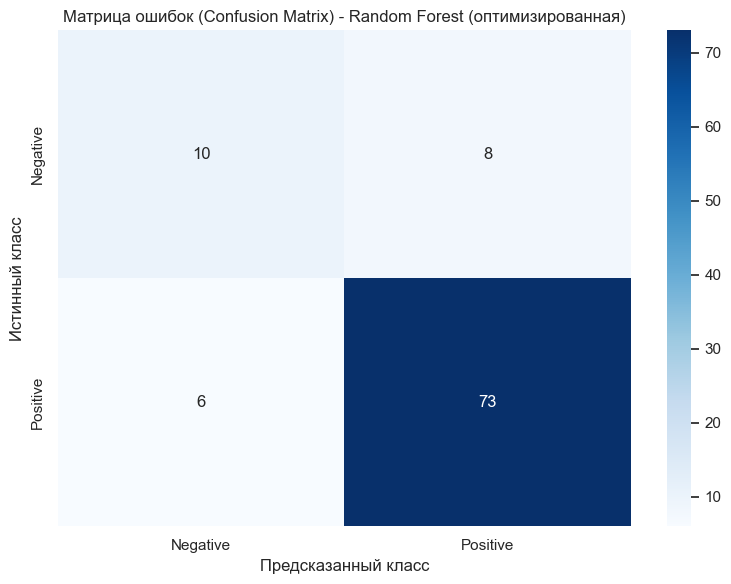

In [23]:
# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title('Матрица ошибок (Confusion Matrix) - Random Forest (оптимизированная)')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.tight_layout()
plt.show()


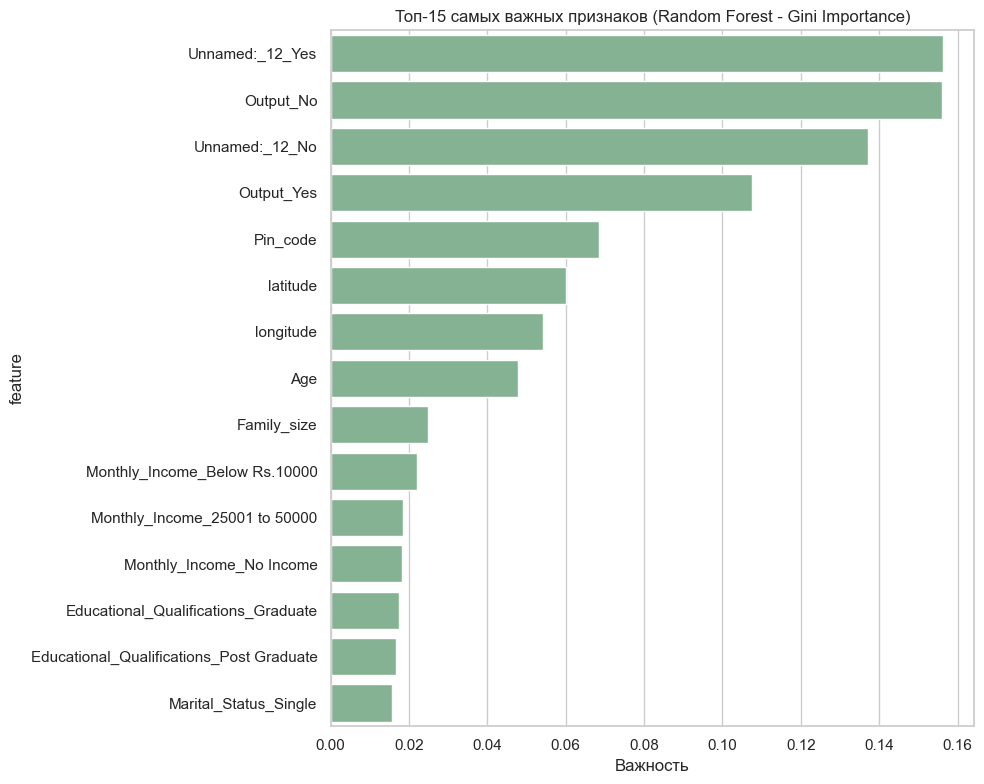

Топ-10 самых важных признаков:


,feature,importance
27,Unnamed:_12_Yes,0.156391
24,Output_No,0.155932
26,Unnamed:_12_No,0.137136
25,Output_Yes,0.107445
4,Pin_code,0.068484
2,latitude,0.060176
3,longitude,0.054244
0,Age,0.047809
1,Family_size,0.024860
16,Monthly_Income_Below Rs.10000,0.021935


In [24]:
# Анализ важности признаков для Random Forest
feature_importances = best_rf_model.feature_importances_

# Получаем имена признаков после предобработки
feature_names = []
if hasattr(preprocessor, 'transformers_'):
    for name, transformer, cols in preprocessor.transformers_:
        if name == 'num':
            feature_names.extend(numeric_cols)
        elif name == 'cat':
            # Для OneHotEncoder получаем имена категорий
            encoder = transformer.named_steps['encoder']
            if hasattr(encoder, 'get_feature_names_out'):
                cat_features = encoder.get_feature_names_out(categorical_cols)
                feature_names.extend(cat_features)
            else:
                feature_names.extend([f'{col}_{i}' for col in categorical_cols for i in range(len(df[col].unique()))])

# Создаем DataFrame с важностью признаков
if len(feature_names) == len(feature_importances):
    features_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    features_df = features_df.sort_values('importance', ascending=False)
    
    # Визуализация важности признаков (топ-15)
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=features_df.head(15))
    plt.title('Топ-15 самых важных признаков (Random Forest - Gini Importance)')
    plt.xlabel('Важность')
    plt.tight_layout()
    plt.show()
    
    # Вывод таблицы с важностью признаков
    print("Топ-10 самых важных признаков:")
    display(features_df.head(10))
else:
    # Если не удалось получить имена, используем индексы
    indices = np.argsort(feature_importances)[::-1]
    plt.figure(figsize=(10, 8))
    plt.barh(range(15), feature_importances[indices][:15])
    plt.yticks(range(15), [f'Feature {i}' for i in indices[:15]])
    plt.gca().invert_yaxis()
    plt.title('Топ-15 самых важных признаков (Random Forest)')
    plt.xlabel('Важность')
    plt.tight_layout()
    plt.show()


In [25]:
# Кросс-валидация для оценки стабильности модели
cv_scores_rf = cross_val_score(best_rf_model, X_train, y_train, cv=5)
cv_scores_gb = cross_val_score(gb_model, X_train, y_train, cv=5)
cv_scores_tuned_dt = cross_val_score(tuned_dt, X_train, y_train, cv=5)

print("Кросс-валидация (5-fold):")
print(f"Random Forest (optimized): {np.mean(cv_scores_rf):.4f} (+/- {np.std(cv_scores_rf) * 2:.4f})")
print(f"Gradient Boosting: {np.mean(cv_scores_gb):.4f} (+/- {np.std(cv_scores_gb) * 2:.4f})")
print(f"Tuned Decision Tree: {np.mean(cv_scores_tuned_dt):.4f} (+/- {np.std(cv_scores_tuned_dt) * 2:.4f})")


Кросс-валидация (5-fold):
Random Forest (optimized): 0.8593 (+/- 0.1020)
Gradient Boosting: 0.8350 (+/- 0.0746)
Tuned Decision Tree: 0.8624 (+/- 0.0878)


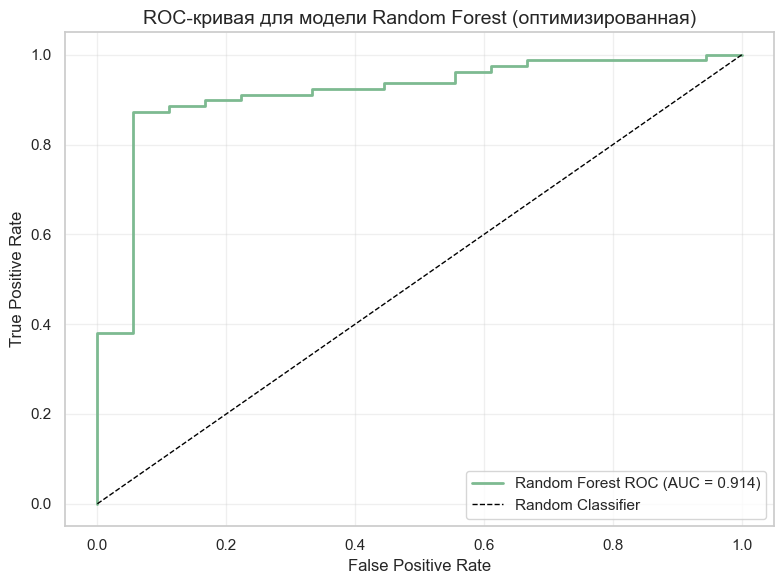

AUC на тестовой выборке: 0.914


In [26]:
# ROC-кривая для лучшей модели
y_proba_best = best_rf_model.predict_proba(X_test)[:, 1]
y_test_binary = (y_test == 'Positive').astype(int)

fpr, tpr, _ = roc_curve(y_test_binary, y_proba_best)
auc_score = roc_auc_score(y_test_binary, y_proba_best)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest ROC (AUC = {auc_score:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC-кривая для модели Random Forest (оптимизированная)', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"AUC на тестовой выборке: {auc_score:.3f}")


## Выводы

* Модель Random Forest показала высокую эффективность на задаче бинарной классификации отзывов об онлайн-заказе еды.
* Подбор гиперпараметров с помощью GridSearchCV позволил улучшить качество модели.
* Сравнение с другими методами (Decision Tree, Gradient Boosting) показало, что ансамблевые методы превосходят одиночное дерево решений.
* Анализ важности признаков позволяет выявить наиболее значимые факторы, влияющие на отзывы клиентов.
* Кросс-валидация подтвердила стабильность результатов модели.
